# Chapter 15 多目的最小二乗法

## 15.1 多目的最小二乗法

複数の目的関数を持つ最小二乗問題を解く関数を定義しよう．
重みは正とする．データデータは，係数行列のリスト（もしくは配列）`As`（各行列の高さは同じではない），対応する（右辺の）ベクトルのリスト`bs`，そして重みの配列（もしくはリスト）`lambda`である．


In [1]:
function mols_solve(As,bs,lambdas)
  k = length(lambdas);
  Atil = vcat([sqrt(lambdas[i])*As[i] for i=1:k]...)
  btil = vcat([sqrt(lambdas[i])*bs[i] for i=1:k]...)
  return Atil \ btil
  end;

### 単純な例

上で定義した関数`mols_solve`を使って，本書の図15.1, 15.2, 15.3のような目的関数が2つある問題を解いてみよう．目的関数は
$$
J_1 + \lambda J_2 = \| A_1 x - b_1 \|^2 + \lambda \| A_2 x - b_2 \|^2
$$
である．ここでは$A_1, A_2$は$10 \times 5$のランダムな行列，$b_1, b_2$はランダムな10次元ベクトルである．式`lambdas = 10 .^ linspace(-4,4,200)`は，対数スケールで等間隔に$\lambda \in [10^{-4}, 10^4]$を200等分した数列を返す．このコードで作成したプロットは図15.1, 15.2, 15.3である．


In [6]:
using VMLS, LinearAlgebra

In [7]:
As = [randn(10,5), randn(10,5)];
bs = [randn(10), randn(10)];
N = 200;
lambdas = 10 .^ linspace(-4,4,200);
x = zeros(5,N);
J1 = zeros(N);
J2 = zeros(N);
for k = 1:N
    x[:,k] = mols_solve(As, bs, [1, lambdas[k]])
    J1[k] = norm(As[1] * x[:,k] - bs[1])^2
    J2[k] = norm(As[2] * x[:,k] - bs[2])^2
end;

In [8]:
using Plots

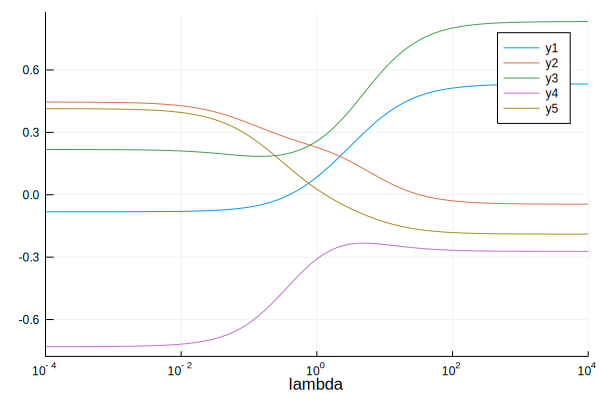

In [9]:
# 横軸をlambdaにして解をプロット
plot(lambdas, x', xscale = :log10, xlabel = "lambda")
plot!(xlims = (1e-4,1e4))

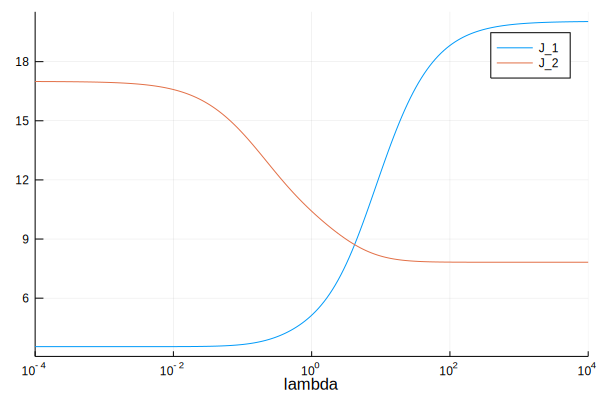

In [10]:
# 横軸をlambdaにして2つの目的関数をプロット
plot(lambdas, J1, xscale = :log10, label = "J_1")
plot!(lambdas, J2, label = "J_2", xlabel = "lambda",
           xlims = (1e-4,1e4))

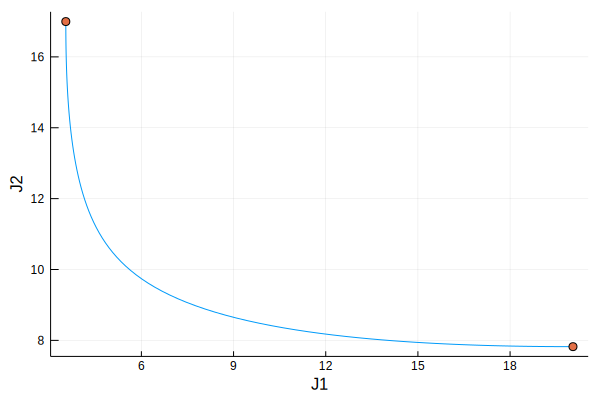

In [11]:
# トレードオフ曲線をプロット
plot(J1, J2, xlabel="J1", ylabel = "J2", legend=false)
# トレードオフ曲線に2つの（目的関数が1つの場合の）点を追加
x1 = As[1] \ bs[1];
x2 = As[2] \ bs[2];
J1 = [norm(As[1]*x1-bs[1])^2, norm(As[1]*x2-bs[1])^2];
J2 = [norm(As[2]*x1-bs[2])^2, norm(As[2]*x2-bs[2])^2];
scatter!(J1,J2)

![図15.1](fig15-1.pdf)

図15.1 2つの目的関数の重み付き和を目的関数とする5変数の2目的最小二乗問題の最小二乗解$\hat{x}(\lambda)$の$\lambda$に対するプロット

![図15.2](fig15-2.pdf)

図15.2 図15.1の2目的最小二乗問題の目的関数$J_1 = \| A_1 \hat{x}(\lambda) b_1 \|^2$（青線）と$J_2 = \| A_2 \hat{x}(\lambda) b_2 \|$（赤線）の$\lambda$に対するプロット

![図15.3](fig15-3.pdf)

図15.3 図15.1と15.2の2目的最小二乗問題の最適トレードオフ


## 15.2 制御

## 15.3 推定とinversion

### 周期的時系列の推定

本書図15.4の例を扱う．1時間毎のオゾンレベルのデータ14日分をベクトルとして読み込む．欠損した観測値は`NaN`になっている（Not a numberの意味）．`plot`コマンドはその値を読み飛ばす（図15.4）．

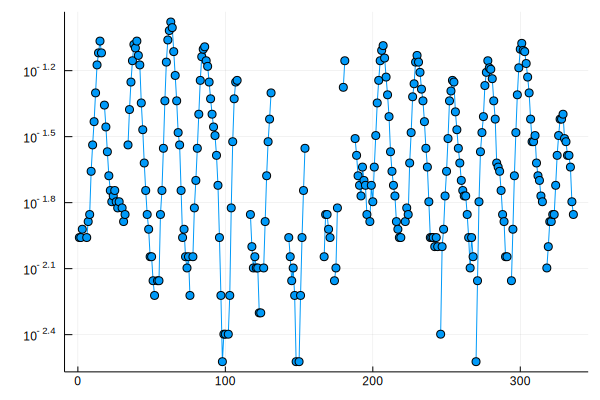

In [12]:
ozone = ozone_data();  # 長さ14*24 = 336のベクトル
k = 14;
N = k * 24;
plot(1:N, ozone, yscale = :log10, marker = :circle, legend=false)

![図15.4](fig15-4.pdf)

図15.4 2014年7月1日午前12時から14日午後11時まで14日間のカリフォルニア州アズサの1時間毎のオゾンレベル（カリフォルニア州環境保護庁, Air Resources Board, www.arb.ca.gov ）．多数の値が欠損しており，特に午後4時の計測値はすべて欠損している．



次に`mols_solve`関数を使って，$\lambda=1$と$\lambda=10$について，周期関数のフィッティングを行う．Juliaのコードでは`isnan`を使って欠損値を除外している．結果を図15.5と15.6に示す．

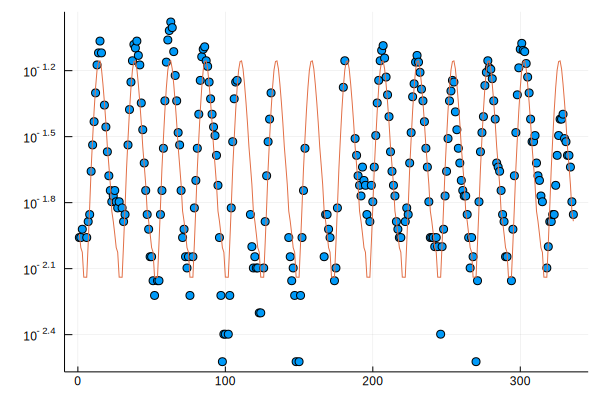

In [13]:
A = vcat( [eye(24) for i = 1:k]...);
# 周期的な差分行列
D = -eye(24) + [zeros(23,1) eye(23); 1  zeros(1,23)];
ind = [k for k in 1:length(ozone) if !isnan(ozone[k])];
As = [A[ind,:], D];
bs = [log.(ozone[ind]), zeros(24)];
# lambda = 1に対する解
x = mols_solve( As, bs, [1, 1]);
scatter(1:N, ozone, yscale = :log10, legend=false)
plot!(1:N, vcat([exp.(x) for i = 1:k]...))

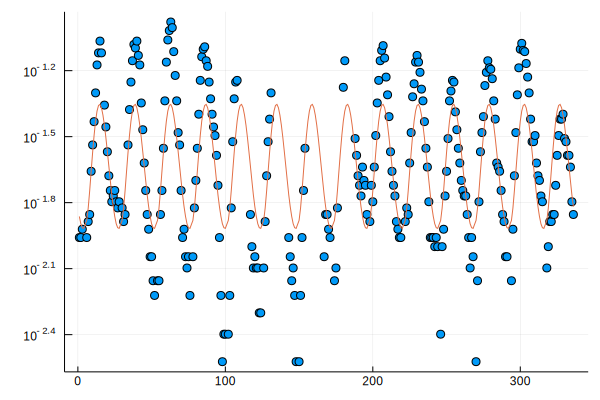

In [14]:
# lambda = 100に対する解
x = mols_solve( As, bs, [1, 100]);
scatter(1:N, ozone, yscale = :log10, legend=false)
plot!(1:N, vcat([exp.(x) for i = 1:k]...))

![図15.5](fig15-5.pdf)

図15.5 $\lambda=1$の
周期的で滑らかな曲線を求める
最小二乗法を対数変換された計測値にフィッティングした結果

![図15.6](fig15-6.pdf)

図15.6 $\lambda=100$の
周期的で滑らかな曲線を求める
最小二乗法を対数変換された計測値にフィッティングした結果



## 15.4　正則化付きデータフィッティング

### 例

次に本書＊＊＊ページの，正則化ありの小規模なデータフィッティングについて考える．ここで使うモデルは
$$
\hat{f} = \sum_{k=1}^5 \theta_k f_k(x)
$$
であり，ここで基底関数は$f_1(x) =1$ついて$f_{k+1}(x) = \sin(\omega_k x + \phi_k)$である．またデータ点数は$N=20$である．$\omega_k$と$\phi_k$については本文中の値を用いる．このモデルをフィッティングするために，以下のような目的関数の正則化付き最小二乗問題を解く．
$$
\sum_{i=1}^N \left(y^{(i)} - \sum_{k=1}^5 \theta_k f_k(x^{(i)}) \right)^2 + \lambda \sum_{k=2}^5 \theta_k^2
$$
このプロットを図15.7と15.8に示す．

In [15]:
# データをベクトルxtrain, ytrain, xtest, ytestとして読み込む
D = regularized_fit_data();
xtrain = D["xtrain"];
ytrain = D["ytrain"];
xtest = D["xtest"];
ytest = D["ytest"];
N = length(ytrain);
Ntest = length(ytest);
p = 5;
omega = [ 13.69; 3.55; 23.25; 6.03 ];
phi = [ 0.21; 0.02; -1.87; 1.72 ];
A = hcat(ones(N), sin.(xtrain*omega' + ones(N)*phi'));
Atest = hcat(ones(Ntest),
sin.(xtest*omega' + ones(Ntest)*phi'));
npts = 100;
lambdas = 10 .^ linspace(-6,6,npts);
err_train = zeros(npts);
err_test = zeros(npts);
thetas = zeros(p,npts);
for k = 1:npts
    theta = mols_solve([ A, [zeros(p-1) eye(p-1)]],
                      [ ytrain, zeros(p-1) ], [1, lambdas[k]])
    err_train[k] = rms(ytrain - A*theta);
    err_test[k] = rms(ytest - Atest*theta);
    thetas[:,k] = theta;
end;

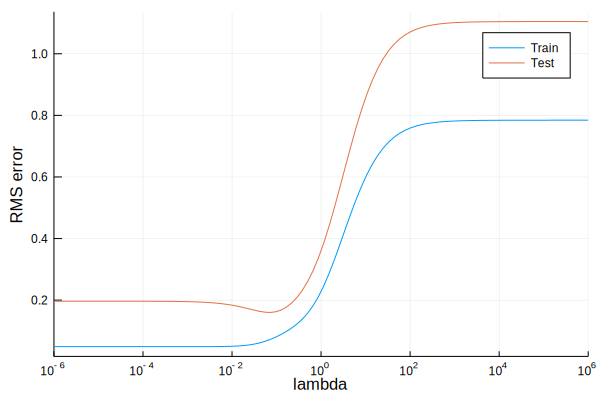

In [17]:
# RMS誤差をプロット
plot(lambdas, err_train, xscale = :log10, label = "Train")
plot!(lambdas, err_test, xscale = :log10, label = "Test")
plot!(xlabel = "lambda", ylabel = "RMS error", xlim = (1e-6, 1e6))

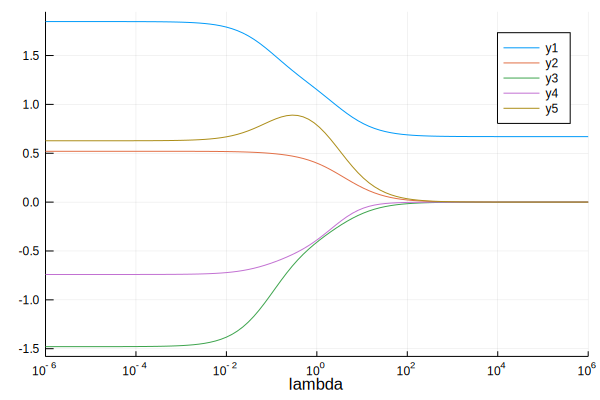

In [18]:
# 係数をプロット
plot(lambdas, thetas', xscale = :log10)
plot!(xlabel = "lambda", xlim = (1e-6, 1e6))

![図15.7](fig15-7.pdf)

図15.7 正則化パラメータ$\lambda$に対するm訓練集合とテスト集合のRMS

![図15.8](fig15-8.pdf)

図15.8 正則化経路


## 15.5 計算量

### カーネルトリック


本書15.5.2節の，カーネルトリックをチェックしよう．これは最小化問題
$$
\| A x - b \|^2 + \lambda \| x - x^\mathrm{des} \|^2
$$
の解$\hat{x}$を求めるものである．ここで$A$は$m \times n$行列，$\lambda > 0$である．$\hat{x}$を求める方法は2つある．1つ目はナイーブな方法で，2つ目はカーネルトリックを用いるものである．以下では，
$$
\begin{bmatrix}
A^T \\
\sqrt{\lambda} I
\end{bmatrix} = QR
$$
とすると
$$
(A A^T + \lambda I)^{-1} = (R^T Q^T Q R)^{-1} = R^{-1} R^{-T}
$$
が成り立つことを利用する．


In [19]:
m = 100;
n = 5000;
A = randn(m, n); 
b = randn(m); 
xdes = randn(n);
lam = 2.0;

In [20]:
# ||Ax-b||^2 + lambda ||x||^2の最小解xを求める
@time xhat1 = [A; sqrt(lam)*eye(n)] \ [b; sqrt(lam)*xdes];

 18.613059 seconds (40.28 k allocations: 1.130 GiB, 1.41% gc time)


In [21]:
# カーネルトリックを用いる
@time begin
Q, R = qr([A' ; sqrt(lam)*eye(m)]);
Q = Matrix(Q);
xhat2 = A' * (R \ (R' \ (b-A*xdes))) + xdes; 
end;

  0.573166 seconds (1.33 M allocations: 78.517 MiB, 30.12% gc time)


In [22]:
norm(xhat1 - xhat2)

1.158936217772683e-13

1つ目のナイーブな方法は$5100 \times 5100$行列の因子分解を必要とするが，2つ目のカーネルトリックは$5100 \times 100$行列の因子分解で済む．